# 1. Import library

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import lightgbm as lgb
print('LightGBM version:', lgb.__version__)
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, StratifiedGroupKFold
from sklearn.ensemble import GradientBoostingClassifier

from matplotlib.patches import Patch
import matplotlib.style as style
import ast

LightGBM version: 4.3.0


# 2. Metadata analysis

In [3]:
def number_of_samples(metadata):
    '''
        Get number of samples without missing label of resistance for each antibiotic
        - Input: metadata (DataFrame)
        - Output: a DataFrame with 2 columns, 'Antibiotic' and 'Number of Samples' correspondingly
    '''
    antibiotic = []; num_of_samples = []
    for j in metadata.columns:
        if j != 'ST':
            antibiotic.append(j); num_of_samples.append(np.sum(~metadata[j].isna()))
    num_of_samples = pd.DataFrame([antibiotic, num_of_samples]).T
    num_of_samples.columns = ['Antibiotic', 'Number of Samples']
    return num_of_samples

### E. coli metadata

In [4]:
Ecoli_metadata = pd.read_csv('./metadataEcoliST.csv')
for c in Ecoli_metadata.columns[2:-1]:
    Ecoli_metadata[c] = Ecoli_metadata[c].map(lambda x: 1 if x in ['R', 'I'] else 0 if x=='S' else x)
Ecoli_metadata.drop(columns=['Isolate', 'Year', 'TZP'], inplace=True)
# 'ST' column in metadata is subtype
Ecoli_metadata = pd.concat([Ecoli_metadata.iloc[:, :11].reindex(sorted(Ecoli_metadata.columns[:11]), axis=1), Ecoli_metadata['ST']], axis=1)
Ecoli_metadata

,AMC,AMP,AMX,CET,CIP,CTX,CTZ,CXM,GEN,TBM,TMP,ST
0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,135
1,1.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10
2,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127
3,0.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10
4,1.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,131
...,...,...,...,...,...,...,...,...,...,...,...,...
1648,0.0,1.0,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,10
1649,0.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,5951
1650,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,88
1651,1.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,654


In [5]:
Ecoli_num_samples = number_of_samples(Ecoli_metadata)
Ecoli_num_samples

,Antibiotic,Number of Samples
0,AMC,1652
1,AMP,562
2,AMX,1090
3,CET,562
4,CIP,1652
5,CTX,1576
6,CTZ,1652
7,CXM,1652
8,GEN,1652
9,TBM,562


### K. pneumoniae metadata

In [19]:
Kp_metadata = pd.read_csv('metadataKpST.csv')
for c in Kp_metadata.columns:
    Kp_metadata[c] = Kp_metadata[c].map(lambda x: 1 if x in ['R', 'I'] else 0 if x=='S' else x)
drop_col = ['Isolate', 'Year', 'amikacin', 'meropenem']
for c in Kp_metadata.columns[2:]:
    if Kp_metadata.shape[0] - Kp_metadata[c].value_counts(dropna=False)[np.nan] < 500:      # drop antibiotics with num of samples is less than 500
        drop_col.append(c)
Kp_metadata = Kp_metadata.drop(columns=drop_col)

mapping_name = {'ampicillin@sulbactam':'AMS', 'aztreonam':'AZT', 'cefazolin':'CZL', 'cefepime':'FEP', 'cefoxitin':'FOX',
                'ceftazidime':'CAZ', 'ceftriaxone':'CTR', 'cefuroxime@sodium':'CXM', 'ciprofloxacin':'CIP', 'gentamicin':'GEN',
                'imipenem':'IPM', 'levofloxacin':'LVX', 'nitrofurantoin':'NIT', 'piperacillin@tazobactam':'TZP', 'tetracycline':'TCY',
                'tobramycin':'TOB', 'trimethoprim@sulfamethoxazole':'SXT', 'ST':'ST'
                }

Kp_metadata.columns = Kp_metadata.columns.map(mapping_name)
Kp_metadata

,AMS,AZT,CZL,FEP,FOX,CAZ,CTR,CXM,CIP,GEN,IPM,LVX,NIT,TZP,TCY,TOB,SXT,ST
0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,258
1,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,258
2,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,0.0,258
3,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,258
4,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,0.0,1.0,1.0,258
2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
2331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
2332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231


In [20]:
Kp_num_samples = number_of_samples(Kp_metadata)
Kp_num_samples

,Antibiotic,Number of Samples
0,AMS,1711
1,AZT,1867
2,CZL,1969
3,FEP,1711
4,FOX,1854
5,CAZ,2051
6,CTR,1919
7,CXM,1626
8,CIP,2239
9,GEN,2196


# 3. Pre-process data

In [2]:
def preprocess(path:str, prefix:str=None):
    '''
        Preprocess data from .npy (numpy format) to pandas DataFrame, drop duplicate columns
        - Input:  
            - path: file path of numpy format data
            - prefix: prefix to mark type of features before combine to PanKA (for features importance), default=None
        - Output: DataFrame
    '''
    df = pd.DataFrame(np.load(path), dtype='float16')
    # drop duplicate columns
    df = df.T.drop_duplicates(keep='first', ignore_index=True).T
    if prefix:
        df.columns = [f'{prefix}{i}' for i in range(df.shape[1])]
    return df

### E. coli data

In [7]:
# KmerDNA
kmer_dna = preprocess(path='./AllKmerDNA-001.npy')

# KmerProtein
kmer_protein = preprocess(path='./AllKmerProtein-002.npy')

# PanPred
panpred = preprocess(path='./PanPred/AMR_data/PanPredPangenomeMatrix.npy')

# PanCore (value 0 corresponding missing value)
coregene = preprocess(path='./amrdata/coregenes.npy', prefix='C')

# AMR Kmer
amr_kmer = preprocess(path='./amrdata/KmerAMRGenePanV9.npy', prefix='K')

# AMR SNPs (value 0 corresponding missing value)
amr_snps = preprocess(path='./amrdata/SNPsAMRGenePanV9.npy')

# PA matrix (presence and absence matrix)
pa_matrix = pd.read_table('./amrdata/gene_presence_absence.Rtab').T
pa_matrix.columns = pa_matrix.values[0]
pa_matrix.drop(index=['Gene'], inplace=True)
pa_matrix.reset_index(drop=True, inplace=True)
pa_matrix = pa_matrix.where(pa_matrix==0, 1).T.drop_duplicates(keep='first', ignore_index=True).T.astype('int16')
pa_matrix.columns = [f'P{i}' for i in range(pa_matrix.shape[1])]

In [8]:
print('Shape of KmerDNA:', kmer_dna.shape)
print('Shape of KmerProtein:', kmer_protein.shape)
print('Shape of PanPred:', panpred.shape)
print('Shape of PanCore:', coregene.shape)
print('Shape of AMR Kmer:', amr_kmer.shape)
print('Shape of SNPsGene: ', amr_snps.shape)
print('Shape of PA matrix:', pa_matrix.shape)

Shape of KmerDNA: (1653, 15435)
Shape of KmerProtein: (1653, 52011)
Shape of PanPred: (1653, 13456)
Shape of PanCore: (1653, 22995)
Shape of AMR Kmer: (1653, 10057)
Shape of SNPsGene:  (1653, 24877)
Shape of PA matrix: (1653, 9518)


In [9]:
panka_snp = pd.concat([amr_snps, coregene, pa_matrix], axis=1).T.drop_duplicates(keep='first', ignore_index=True).T
print('Shape of PanKA (AMR SNPs + PAmatrix + PanCore):', panka_snp.shape)
panka = pd.concat([coregene, amr_kmer, pa_matrix], axis=1).T.drop_duplicates(keep='first').T
print('Shape of PanKA:', panka.shape)

Shape of PanKA (AMR SNPs + PAmatrix + PanCore): (1653, 56848)
Shape of PanKA: (1653, 42477)


### K. pneumoniae data

In [10]:
# KmerDNA
Kp_KmerDNA = preprocess(path='amrdata/Kp/KpFullKmer/DNAKmer.npy')

# KmerProtein
Kp_KmerProtein = preprocess(path='amrdata/Kp/KpFullKmer/ProteinKmer.npy')

# PanPred
Kp_PanPred = preprocess(path='amrdata/Kp/KpPanPredPangenome.npy')

# PanCore
Kp_Core = preprocess(path='amrdata/Kp/KpPatricCoreGeneLabelEncoderMatTop2kTrue.npy', prefix='C')

# AMR Kmer
Kp_AMR_Kmer = preprocess(path='amrdata/Kp/KpPatricKmerEncoderAMRGenes.npy', prefix='K')

# AMR SNPs
Kp_AMR_SNPs = preprocess(path='amrdata/Kp/KpAMRGeneLabelEncoderMatTop20k.npy')

# PA matrix
Kp_pa_matrix = pd.DataFrame(np.load('amrdata/Kp/KppantaRtab.npy'), dtype='float16')
Kp_pa_matrix = Kp_pa_matrix.where(Kp_pa_matrix==0, 1).T.drop_duplicates(keep='first', ignore_index=True).T
Kp_pa_matrix.columns = [f'P{i}' for i in range(Kp_pa_matrix.shape[1])]

In [11]:
print('Shape of KmerDNA:', Kp_KmerDNA.shape)
print('Shape of KmerProtein:', Kp_KmerProtein.shape)
print('Shape of PanPred:', Kp_PanPred.shape)
print('Shape of PanCore:', Kp_Core.shape)
print('Shape of AMR Kmer:', Kp_AMR_Kmer.shape)
print('Shape of Kp_AMR_SNPs:', Kp_AMR_SNPs.shape)
print('Shape of PA matrix:', Kp_pa_matrix.shape)

Shape of KmerDNA: (2334, 157249)
Shape of KmerProtein: (2334, 126110)
Shape of PanPred: (2334, 31441)
Shape of PanCore: (2334, 17233)
Shape of AMR Kmer: (2334, 17995)
Shape of Kp_AMR_SNPs: (2334, 11070)
Shape of PA matrix: (2334, 14304)


In [12]:
Kp_panka_snp = pd.concat([Kp_AMR_SNPs, Kp_Core, Kp_pa_matrix], axis=1).T.drop_duplicates(keep='first', ignore_index=True).T
print('Kp PanKA (AMR SNPs + PanCore + PAmatrix):', Kp_panka_snp.shape)
Kp_panka = pd.concat([Kp_Core, Kp_AMR_Kmer, Kp_pa_matrix], axis=1).T.drop_duplicates(keep='first').T
print('Kp PanKA:', Kp_panka.shape)

Kp PanKA (AMR SNPs + PanCore + PAmatrix): (2334, 41999)
Kp PanKA: (2334, 49425)


# 4. Define functions

In [13]:
# combine features and labels -> drop rows with missing label -> drop duplicates columns
def prepare_data(data:pd.DataFrame, metadata:pd.DataFrame, antibiotic:str, return_ST=False):
    '''
        Merge data (X) with label (y)
        - Input:  
            - data: DataFrame, output of preprocess() function
            - if return_ST = True, information of subtype (ST) will be merged like group
        - Output: DataFrame (with X, y [, group])
    '''
    df = pd.concat([data, metadata[[antibiotic, 'ST']]], axis=1).dropna(subset=[antibiotic])
    df = pd.concat([df.iloc[:, :-2].T.drop_duplicates(keep='first', ignore_index=True).T, df.iloc[:, -2:]], axis=1)
    if return_ST == False:
        df.drop(columns=['ST'], inplace=True)
    return df.reset_index(drop=True)

# create a clasification model with default params and grid search params
def model(method):
    '''
        Create model with specific method and parameters to use in GridSearchCV
        - Input: 
            - method: "LGBM" (LightGBM) or "GBDT" (GradientBoostingDecisionTree), not supported otherwise
        - Output: model and parameters grid
    '''
    if method == 'GBDT':
        params = {
            'random_state': 10
        }
        clf = GradientBoostingClassifier(**params)
        param_grid = {
            'max_features': ['sqrt', 'log2', 1000],
            'n_estimators': [300, 600, 5000],
            'max_depth': [3, 10],
            'min_samples_leaf': [1, 5]
        }
    elif method == 'LGBM':
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'device': 'cpu',
            'n_estimators': 100,
            'n_jobs': 2,
            'force_col_wise': True,
            'verbose': -1
        }
        clf = lgb.LGBMClassifier(**params)
        param_grid = {
            'max_depth': [5, 7, 9, 11],
            'max_bin': [2, 3, 4, 8],
            'num_leaves': [31, 63],
            'min_child_samples':[5, 20]
        }
    else:
        raise(KeyError(f'Method {method} is not supported!'))
    return clf, param_grid

def custom_cv_Ecoli(data: pd.DataFrame, groups=[[131, 95],
                                [10, 127, 405, 38, 393, 14, 80, 62, 59, 357, 141, 648, 58],
                                [131, 12, 10, 127],
                                [95, 10, 405, 38, 393, 88, 144, 14, 80],
                                [131, 69]]):
    '''
        Customize 5 folds with specific subtypes (ST) for cross-validation
        - Input:  
            - data: DataFrame, output of preprocess() function
            - groups: list groups of subtypes in test set
        - Output: yield train index and test index for 5 folds
    '''
    for group_idx in groups:
        test_idx = np.where(data['ST'].isin(group_idx))[0]
        train_idx = np.where(~data['ST'].isin(group_idx))[0]
        yield train_idx, test_idx

In [14]:
# run GridSearchCV: one antibiotic with various data
def run_gridSearchCV(antibiotic:str, method:str, metadata:pd.DataFrame, all_data:dict, random_state:int=44,
                     validate_ST:bool=False, validate_5times:bool=False, n_jobs:int=-1):
    '''
        Run GridSearchCV for 1 antibiotic with various data to find the best set of params for each data
        - Input:
            - antibiotic: stand for name of antibiotic (like 'ciprofloxacin':'CIP', 'gentamicin':'GEN',...)
            - method: "LGBM" or "GBDT"
            - metadata: DataFrame
            - all_data: dict with keys (name of data) and values (DataFrame corresponding)
            - random_state: random state of StratifiedKFold
            - validate_ST: if True, prepare_data() function return data with groups of subtypes (ST)
            - validate_5times: if True, run GridSearchCV 5 times with 5 folds, once otherwise
            - n_jobs: number of jobs to run in parallel, default = -1 means using all processors
        - Output: Return DataFrame with metrics and the best parameters
    '''
    t = time.time()
    type_data, all_F1, all_precision, all_recall, all_params = [], [], [], [], []

    for key in all_data.keys():
        print(f'\t Running in data {key}...')
        t1 = time.time()
        type_data.append(key + f' {method}')
        folds_F1, folds_precision, folds_recall, folds_params = [], [], [], []

        # prepare data for model
        data = prepare_data(all_data[key], metadata, antibiotic, return_ST=validate_ST)

        # if validate with subtypes (validate_ST=True): split data with custom cross validation
        # else: split data with StratifiedKFold
        if validate_ST:
            X = data.iloc[:, :-2]
            y = data.iloc[:, -2]
            skf = custom_cv_Ecoli(data=data)
        else:
            X = data.iloc[:, :-1]
            y = data.iloc[:, -1]
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state).split(X, y)

        # train with GridSearchSV for 4 folds and evaluate in 1 retain fold.
        # if validate 5 times: cross validation like that 5 times
        # else: cross validation once.
        num = 0
        for id_train, id_test in skf:
            num += 1
            if validate_5times == False and num > 1:
                break
            
            # create a classification model and GridSearchCV
            clf, param_grid = model(method=method)
            grid_search = GridSearchCV(
                estimator=clf,
                param_grid=param_grid,
                cv=5,
                n_jobs=n_jobs,
                scoring={'AUC':'roc_auc', 'F1_score':'f1', 'Precision':'precision', 'Recall':'recall'},
                refit='AUC',
                verbose=0
            )
            X_train = X.iloc[id_train, :]; y_train = y.iloc[id_train]
            X_test = X.iloc[id_test, :]; y_test = y.iloc[id_test]

            # run grid search
            grid_search.fit(X=X_train, y=y_train)
            
            # save cv results and find best params with highest F1-score
            cv_results = grid_search.cv_results_
            arg_best_F1 = np.argmin(cv_results['rank_test_F1_score'])
            params_best_F1 = cv_results['params'][arg_best_F1]
            
            # re-train on full data_train 
            if method == 'LGBM':
                params_best_F1.update({
                    'objective': 'binary',
                    'metric': 'binary_logloss',
                    'device': 'cpu',
                    'n_estimators': 100,
                    'n_jobs': 2,
                    'force_col_wise': True,
                    'verbose': -1
                })
                clf = lgb.LGBMClassifier(**params_best_F1)
            else:
                params_best_F1.update({
                    'random_state': 10
                })
                clf = GradientBoostingClassifier(**params_best_F1)

            clf.fit(X=X_train, y=y_train)
            y_pred = clf.predict(X_test)

            # save results
            folds_F1.append(f1_score(y_true=y_test, y_pred=y_pred))
            folds_precision.append(precision_score(y_true=y_test, y_pred=y_pred))
            folds_recall.append(recall_score(y_true=y_test, y_pred=y_pred))
            folds_params.append(params_best_F1)

        print('\t 5 folds F1-score:', folds_F1)
        print(f' ---Running time: {(time.time() - t1) / 60} mins---')
        
        all_F1.append(folds_F1); all_precision.append(folds_precision)
        all_recall.append(folds_recall); all_params.append(folds_params)

    summary = pd.DataFrame([type_data, all_F1, all_precision, all_recall, all_params],
                            index=['Type data', 'All F1', 'All precision', 'All recall', 'All params']).T
    print(f'---Time running: {(time.time() - t) / 60} mins---\n')
    return summary

In [15]:
# run GridSearchCV for various antibiotics
def run_various_antibiotic(antibiotics, method:str, metadata:pd.DataFrame, all_data:dict, random_state:int=44,
                            validate_ST:bool=False, validate_5times:bool=False, n_jobs:int=-1):
    '''
        Run function run_gridSearchCV() with various antibiotics
        - Input: 
            - antibiotics: list (sequence type) of antibiotics
            - details of other hyperparameters like run_gridSearchCV() function
        - Output: Return DataFrame with metrics, the best parameters and antibiotics
    '''
    summary = pd.DataFrame([], columns=['Type data', 'All F1', 'All precision', 'All recall', 'All params', 'Antibiotic'])
    for antibiotic in antibiotics:
        print(f'Run in antibiotic {antibiotic}:')
        temp = run_gridSearchCV(antibiotic, method, metadata, all_data, random_state,
                                validate_ST, validate_5times, n_jobs)
        temp['Antibiotic'] = antibiotic
        summary = pd.concat([summary, temp], axis=0, ignore_index=True)
    return summary

# 5. Run LightGBM and GBDT models for Ecoli and Kp datasets

### Run with Ecoli datasets: train with 4 folds to obtain the best params and evaluate metrics on retain fold

In [ ]:
Ecoli_all_data = {
    'KmerDNA': kmer_dna, 
    'KmerProtein': kmer_protein,
    'PanPred': panpred, 
    'AMR SNPs': amr_snps, 
    'PanKA (AMR SNPs)': panka_snp,
    'AMR Kmer': amr_kmer, 
    'PanKA': panka
}
all_summary_Ecoli_LGBM = run_various_antibiotic(antibiotics=Ecoli_metadata.columns[:-1],
                                                method='LGBM',
                                                metadata=Ecoli_metadata,
                                                all_data=Ecoli_all_data,
                                                validate_ST=False, validate_5times=False, 
                                                random_state=44, n_jobs=16)

In [ ]:
all_summary_Ecoli_GBDT = run_various_antibiotic(antibiotics=Ecoli_metadata.columns[:-1],
                                                method='GBDT',
                                                metadata=Ecoli_metadata,
                                                all_data={'PanPred': panpred},
                                                validate_ST=False, validate_5times=False, 
                                                random_state=44, n_jobs=16)

In [ ]:
all_results_Ecoli = pd.concat([all_summary_Ecoli_LGBM, all_summary_Ecoli_GBDT],
                              axis=0, ignore_index=True)
all_results_Ecoli.to_csv('all_results_Ecoli_rs44.csv', index=False)

### Run with Ecoli datasets: cross-validation 5 folds to plot distribution of metrics

In [ ]:
all_summary_Ecoli_5folds_LGBM = run_various_antibiotic(antibiotics=Ecoli_metadata.columns[:-1],
                                                        method='LGBM',
                                                        metadata=Ecoli_metadata,
                                                        all_data={
                                                            'KmerDNA': kmer_dna, 
                                                            'KmerProtein': kmer_protein,
                                                            'PanPred': panpred,
                                                            'PanKA': panka,
                                                        },
                                                        validate_ST=True, validate_5times=True, 
                                                        n_jobs=16)

In [ ]:
all_summary_Ecoli_5folds_GBDT = run_various_antibiotic(antibiotics=Ecoli_metadata.columns[:-1],
                                                        method='GBDT',
                                                        metadata=Ecoli_metadata,
                                                        all_data={
                                                            'PanPred': panpred,
                                                        },
                                                        validate_ST=True, validate_5times=True, 
                                                        n_jobs=16)

In [ ]:
all_summary_Ecoli_5folds = pd.concat([all_summary_Ecoli_5folds_LGBM, all_summary_Ecoli_5folds_GBDT],
                                     axis=0, ignore_index=True)
all_summary_Ecoli_5folds.to_csv('all_results_Ecoli_5folds_ST.csv', index=False)

### Run with Kp datasets: train with 4 folds to obtain the best params and evaluate metrics on retain fold

In [ ]:
Kp_all_data = {
    'KmerDNA': Kp_KmerDNA, 
    'KmerProtein': Kp_KmerProtein,
    'PanPred': Kp_PanPred, 
    'AMR SNPs': Kp_AMR_SNPs, 
    'PanKA (AMR SNPs)': Kp_panka_snp,
    'AMR Kmer': Kp_AMR_Kmer, 
    'PanKA': Kp_panka
}
all_summary_Kp_LGBM = run_various_antibiotic(antibiotics=Kp_metadata.columns[:-1],
                                            method='LGBM',
                                            metadata=Kp_metadata,
                                            all_data=Kp_all_data,
                                            validate_ST=False, validate_5times=False, 
                                            random_state=44, n_jobs=16)

In [ ]:
all_summary_Kp_LGBM = run_various_antibiotic(antibiotics=Kp_metadata.columns[:-1],
                                            method='GBDT',
                                            metadata=Kp_metadata,
                                            all_data={'PanPred': panpred},
                                            validate_ST=False, validate_5times=False, 
                                            random_state=44, n_jobs=16)

In [ ]:
all_results_Kp = pd.concat([all_summary_Kp_LGBM, all_summary_Kp_LGBM],
                              axis=0, ignore_index=True)
all_results_Kp.to_csv('all_results_Kp_rs44.csv', index=False)

# 6. Visualization

In [22]:
def preprocess_result(result_path:str, metric='All F1'):
    '''
        Flatten list of metrics in result file to plot easier
        - Input:
            - result_path: path of result file
            - metric: choose one of metric: "All F1" (F1-score), "All recall" (Recall) or "All precision" (Precision)
        - Output: DataFrame
    '''
    df = pd.read_csv(result_path)
    df[metric] = df[metric].apply(ast.literal_eval)
    data = []
    for _, row  in df.iterrows():
        for value in row[metric]:
            data.append({
                'Antibiotic': row['Antibiotic'],
                'Type data': row['Type data'],
                metric: value
            })
    return pd.DataFrame(data)

### Barplot

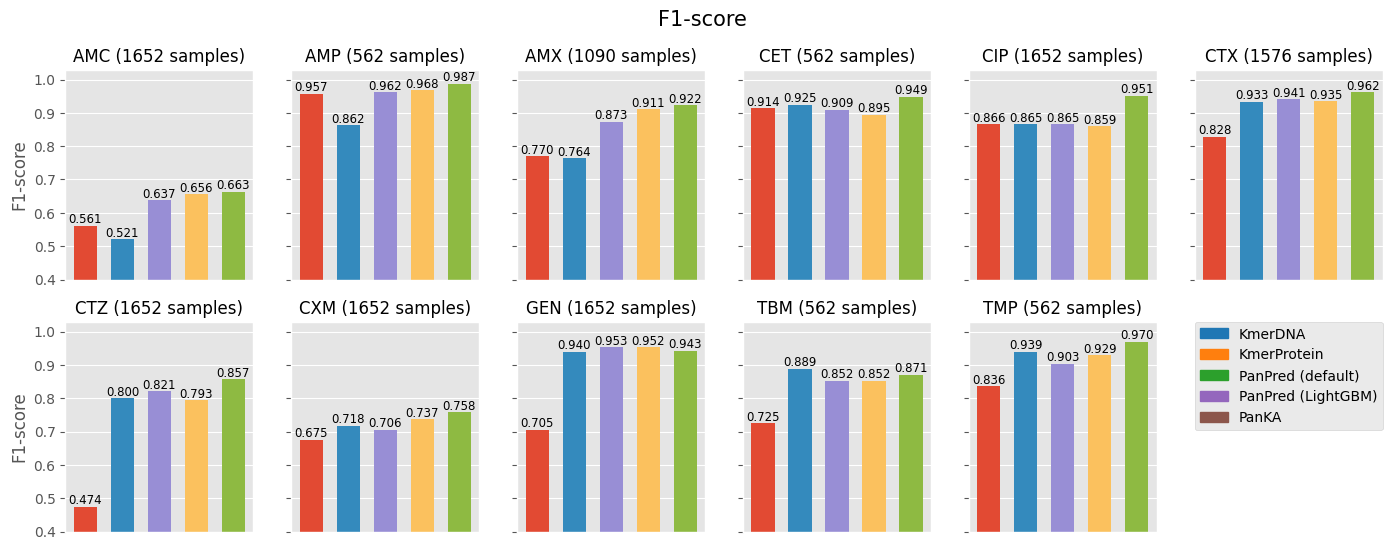

In [23]:
df = preprocess_result('all_results_Ecoli_rs44.csv')

labels_order = ['KmerDNA LGBM', 'KmerProtein LGBM', 'PanPred GBDT', 'PanPred LGBM', 'PanKA LGBM']
legend_order = ['KmerDNA', 'KmerProtein', 'PanPred (default)', 'PanPred (LightGBM)', 'PanKA']
color_custom = ['C0', 'C1', 'C2', 'C4', 'C5']
legend_custom = []
for idx, label in enumerate(labels_order):
    legend_custom.append(Patch(color=color_custom[idx], label=legend_order[idx]))

x = [0, 1.2, 2.4, 3.6, 4.8]
antibiotics = Ecoli_metadata.columns[:-1]

style.use('ggplot')
plt.figure(figsize=(17, 6.)); plt.suptitle('F1-score', fontsize=15)
for idx, anti in enumerate(antibiotics):
    num = Ecoli_num_samples[Ecoli_num_samples['Antibiotic']==anti]['Number of Samples'].values[0]
    ax = plt.subplot(2, 6, idx+1); plt.title(f'{anti} ({num} samples)', fontsize=12)
    plt.ylim(0.4, 1.03)

    for i, label in enumerate(labels_order):
        ax.bar(x[i], df[(df['Type data']==label) & (df['Antibiotic']==anti)]['All F1'], 
                width=0.75, color=color_custom[i])
            
    if idx % 6 == 0:
        ax.set_ylabel('F1-score', fontsize=12)
    else:
        ax.set_yticklabels([])

    ax.set_xticklabels([]); ax.set_xticks([])
    for j in ax.containers:
        ax.bar_label(j, fmt='%.3f', fontsize=8.5)

plt.subplot(2, 6, 12).axis('off')
plt.legend(handles=legend_custom, loc='upper left', borderaxespad=0., fontsize=10)
# plt.savefig('./F1_Ecoli_rs44.jpg', dpi=400, bbox_inches='tight')
plt.show()

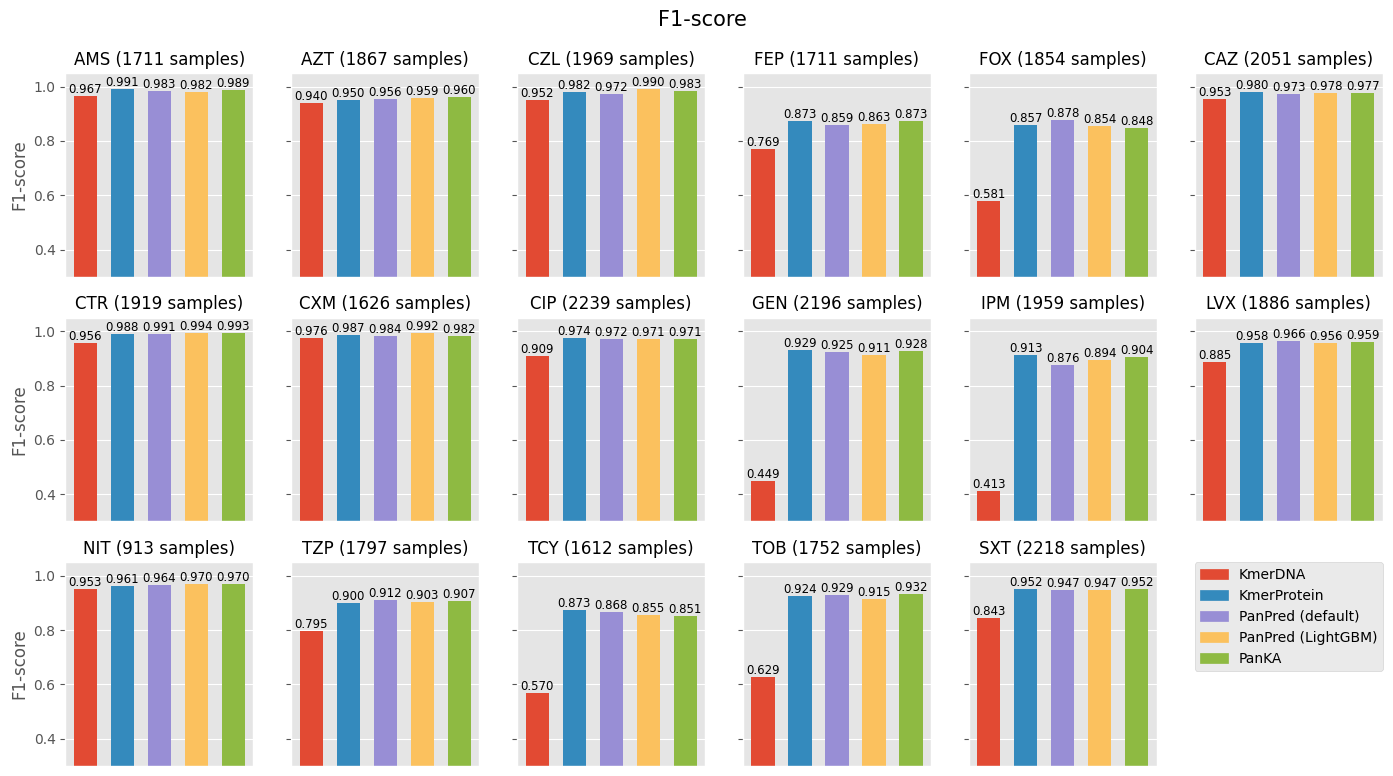

In [24]:
df = preprocess_result('all_results_Kp_rs44.csv')

labels_order = ['KmerDNA LGBM', 'KmerProtein LGBM', 'PanPred GBDT', 'PanPred LGBM', 'PanKA LGBM']
legend_order = ['KmerDNA', 'KmerProtein', 'PanPred (default)', 'PanPred (LightGBM)', 'PanKA']
color_custom = ['C0', 'C1', 'C2', 'C4', 'C5']
legend_custom = []
for idx, label in enumerate(labels_order):
    legend_custom.append(Patch(color=color_custom[idx], label=legend_order[idx]))

x = [0, 1.2, 2.4, 3.6, 4.8]
antibiotics = Kp_metadata.columns[:-1]

style.use('ggplot')
plt.figure(figsize=(17, 9)); plt.suptitle('F1-score', fontsize=15, y=0.95)
for idx, anti in enumerate(antibiotics):
    num = Kp_num_samples[Kp_num_samples['Antibiotic']==anti]['Number of Samples'].values[0]
    ax = plt.subplot(3, 6, idx+1); plt.title(f'{anti} ({num} samples)', fontsize=12)
    plt.ylim(0.3, 1.05)

    for i, label in enumerate(labels_order):
        ax.bar(x[i], df[(df['Type data']==label) & (df['Antibiotic']==anti)]['All F1'], 
                width=0.75, color=color_custom[i])
            
    if idx % 6 == 0:
        ax.set_ylabel('F1-score', fontsize=12)
    else:
        ax.set_yticklabels([])

    ax.set_xticklabels([]); ax.set_xticks([])
    for j in ax.containers:
        ax.bar_label(j, fmt='%.3f', fontsize=8.5)

plt.subplot(3, 6, 18).axis('off')
plt.legend(handles=legend_custom, loc='upper left', borderaxespad=0., fontsize=10)
# plt.savefig('./F1_Kp_rs44.jpg', dpi=400, bbox_inches='tight')
plt.show()

### 5-folds distribution plot

In [25]:
def distribution_5folds_plot(result_path:str, metric:str, title:str, ylabel:str):
    style.use('ggplot')
    df = preprocess_result(result_path=result_path, metric=metric)
    selected_types = ['KmerDNA LGBM', 'KmerProtein LGBM', 'PanPred GBDT', 'PanPred LGBM', 'PanKA LGBM']
    custom_labels = ['KmerDNA', 'KmerProtein', 'PanPred (default)', 'PanPred (LightGBM)', 'PanKA']
    df = df[df['Type data'].isin(selected_types)]

    plt.figure(figsize=(17, 6))
    ax = sns.boxplot(data=df, width=0.65,
                    x='Antibiotic', y=metric, hue='Type data', 
                    hue_order=selected_types,
                    palette=['C0', 'C1', 'C2', 'C4', 'C5'])
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=custom_labels)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

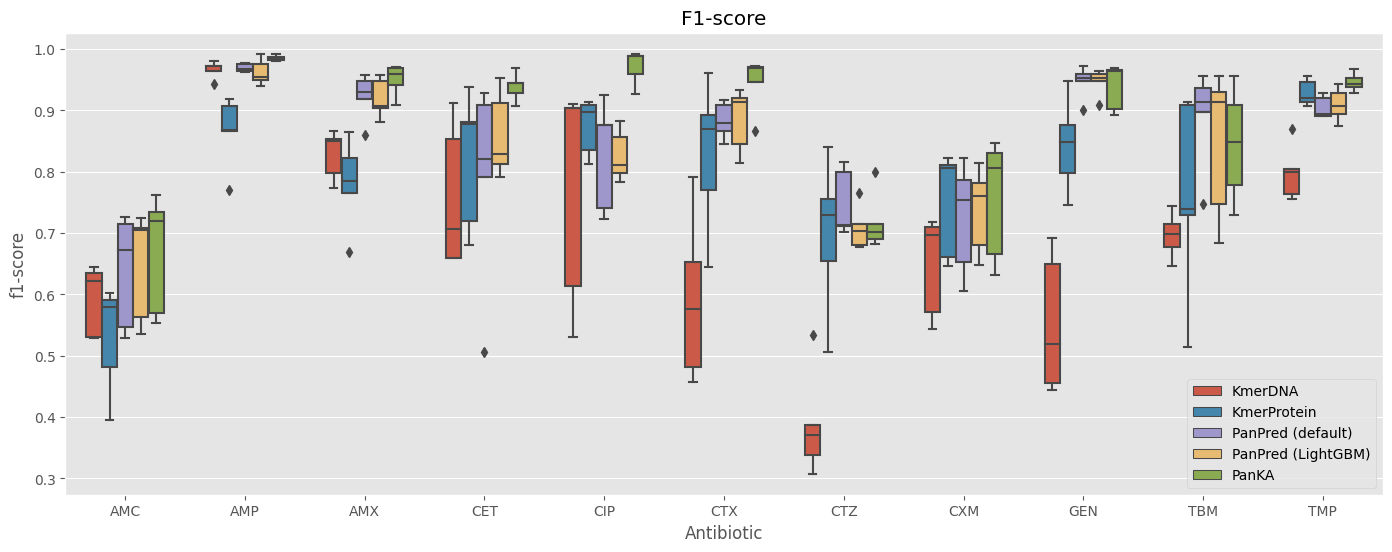

In [26]:
distribution_5folds_plot(result_path='all_results_Ecoli_5folds_ST.csv', 
                         metric='All F1', 
                         title='F1-score', ylabel='f1-score')

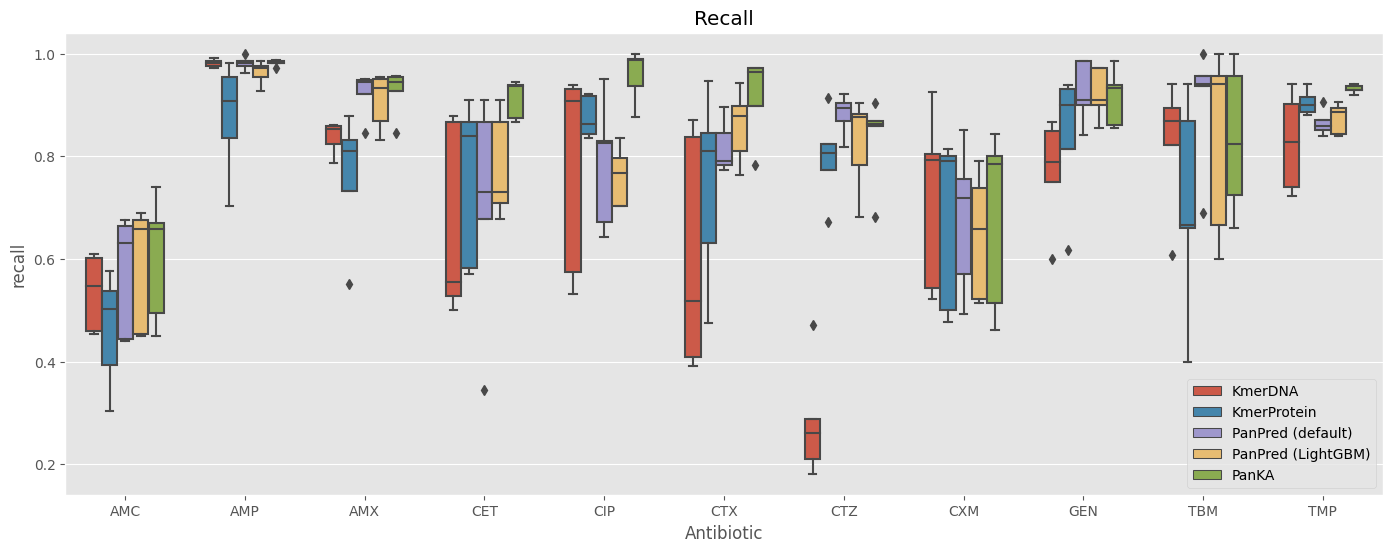

In [27]:
distribution_5folds_plot(result_path='all_results_Ecoli_5folds_ST.csv', 
                         metric='All recall', 
                         title='Recall', ylabel='recall')

### Features importance

In [28]:
def feature_ranking(antibiotics, metadata, data, result:pd.DataFrame, type_importance='gain', random_state:int=44):
    '''
        Refit model with the best set of parameters and get the top 10 most important features
        - Input:
            - antibiotics: list (sequence type) of antibiotics
            - metadata: DataFrame
            - data: output of preprocess() function
            - result: DataFrame, output of run_various_antibiotic() function
            - type_importance: "gain" or "split", details on https://lightgbm.readthedocs.io
            - random_state: random state of StratifiedKFold
        - Output: the top 10 most important features and corresponding values
    '''
    results = []
    for anti in antibiotics:
        best_params = result[(result['Antibiotic']==anti) & 
                             (result['Type data']=='PanKA LGBM')]['All params'].values[0][1:-1].replace("'", '"').replace("True", "true")
        params = json.loads(best_params)
        print('Params for', anti, ':', params)
        params.update({
            'objective': 'binary',
            'metric': 'binary_logloss',
            'device': 'cpu',
            'n_jobs': 2,
            'force_col_wise': True,
            'importance_type': type_importance,
            'verbose': -1
        })
        clf = lgb.LGBMClassifier(**params)

        combined_data = pd.concat([data, metadata[anti]], axis=1).dropna(subset=[anti])
        combined_data = pd.concat([combined_data.iloc[:, :-1].T.drop_duplicates(keep='first').T, 
                                   combined_data.iloc[:, -1:].astype('float16')], axis=1).reset_index(drop=True)
        X = combined_data.iloc[:, :-1]; y = combined_data.iloc[:, -1]
    
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        num = 0
        for train_index, _ in kfold.split(X, y):
            num += 1
            if num > 1:
                break
            clf.fit(X.iloc[train_index, :], y[train_index])

        # check position of feature
        columns = np.array(X.columns.values, dtype=str)
        top_10_fts = np.argsort(clf.feature_importances_)[-10:]
        results.append([columns[top_10_fts], clf.feature_importances_[top_10_fts]])

    return results

In [29]:
ft_rank_Ecoli_gain = feature_ranking(Ecoli_metadata.columns[:-1], Ecoli_metadata, panka, 
                                    pd.read_csv('all_results_Ecoli_rs44.csv'), type_importance='gain')

Params for AMC : {'max_bin': 2, 'max_depth': 7, 'min_child_samples': 5, 'num_leaves': 63, 'objective': 'binary', 'metric': 'binary_logloss', 'device': 'cpu', 'n_estimators': 100, 'n_jobs': 2, 'force_col_wise': True, 'verbose': -1}
Params for AMP : {'max_bin': 8, 'max_depth': 5, 'min_child_samples': 5, 'num_leaves': 31, 'objective': 'binary', 'metric': 'binary_logloss', 'device': 'cpu', 'n_estimators': 100, 'n_jobs': 2, 'force_col_wise': True, 'verbose': -1}
Params for AMX : {'max_bin': 8, 'max_depth': 5, 'min_child_samples': 5, 'num_leaves': 31, 'objective': 'binary', 'metric': 'binary_logloss', 'device': 'cpu', 'n_estimators': 100, 'n_jobs': 2, 'force_col_wise': True, 'verbose': -1}
Params for CET : {'max_bin': 2, 'max_depth': 5, 'min_child_samples': 5, 'num_leaves': 31, 'objective': 'binary', 'metric': 'binary_logloss', 'device': 'cpu', 'n_estimators': 100, 'n_jobs': 2, 'force_col_wise': True, 'verbose': -1}
Params for CIP : {'max_bin': 4, 'max_depth': 7, 'min_child_samples': 5, 'num

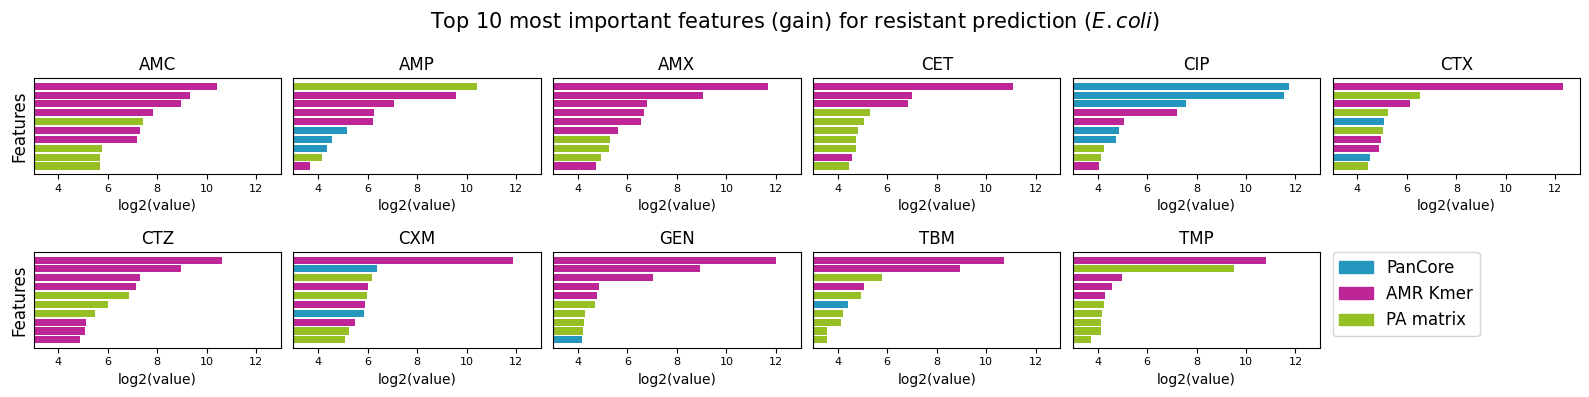

In [30]:
style.use('default')
plt.figure(figsize=(16, 4)); plt.suptitle('Top 10 most important features (gain) for resistant prediction ($\it{E. coli}$)', fontsize=15)
for i in range(11):
    ax = plt.subplot(2, 6, i+1)
    ax.barh(ft_rank_Ecoli_gain[i][0], np.log2(ft_rank_Ecoli_gain[i][1]), height=0.8, 
            color=np.where(np.isin(ft_rank_Ecoli_gain[i][0], coregene.columns), '#2596be', 
                           np.where(np.isin(ft_rank_Ecoli_gain[i][0], amr_kmer.columns), '#be2596', '#96be25')))
    if i%6 == 0:
        plt.ylabel('Features', fontsize=12)
    plt.xticks(fontsize=8)
    plt.title(Ecoli_metadata.columns[i], fontsize=12)
    plt.xlabel('log2(value)', fontsize=10); plt.yticks(ticks=[]); 
    plt.xlim((3, 13))
    plt.tight_layout(h_pad=1.2, w_pad=0.9)
    # plt.show()
plt.subplot(2, 6, 12).axis('off')
legend_custom = [
    Patch(color='#2596be', label='PanCore'),
    Patch(color='#be2596', label='AMR Kmer'),
    Patch(color='#96be25', label='PA matrix')
]
plt.legend(handles=legend_custom, loc='upper left', borderaxespad=0., fontsize=12)
# plt.savefig('figure_ft_importance/fts_ranking_Ecoli_gain.jpg', format='jpg', dpi=400)
plt.show()

In [69]:
# same for type_importance = 'split'

In [107]:
ft_rank_Kp_gain = feature_ranking(Kp_metadata.columns[:-1], Kp_metadata, Kp_panka, 
                                    pd.read_csv('all_results_Kp_rs44.csv'), type_importance='gain')

Params for AMS : {'max_bin': 3, 'max_depth': 11, 'min_child_samples': 20, 'num_leaves': 31, 'objective': 'binary', 'metric': 'binary_logloss', 'device': 'cpu', 'n_estimators': 100, 'n_jobs': 2, 'force_col_wise': True, 'verbose': -1}
Params for AZT : {'max_bin': 8, 'max_depth': 9, 'min_child_samples': 5, 'num_leaves': 31, 'objective': 'binary', 'metric': 'binary_logloss', 'device': 'cpu', 'n_estimators': 100, 'n_jobs': 2, 'force_col_wise': True, 'verbose': -1}
Params for CZL : {'max_bin': 3, 'max_depth': 7, 'min_child_samples': 5, 'num_leaves': 63, 'objective': 'binary', 'metric': 'binary_logloss', 'device': 'cpu', 'n_estimators': 100, 'n_jobs': 2, 'force_col_wise': True, 'verbose': -1}
Params for FEP : {'max_bin': 2, 'max_depth': 7, 'min_child_samples': 20, 'num_leaves': 31, 'objective': 'binary', 'metric': 'binary_logloss', 'device': 'cpu', 'n_estimators': 100, 'n_jobs': 2, 'force_col_wise': True, 'verbose': -1}
Params for FOX : {'max_bin': 8, 'max_depth': 9, 'min_child_samples': 5, '

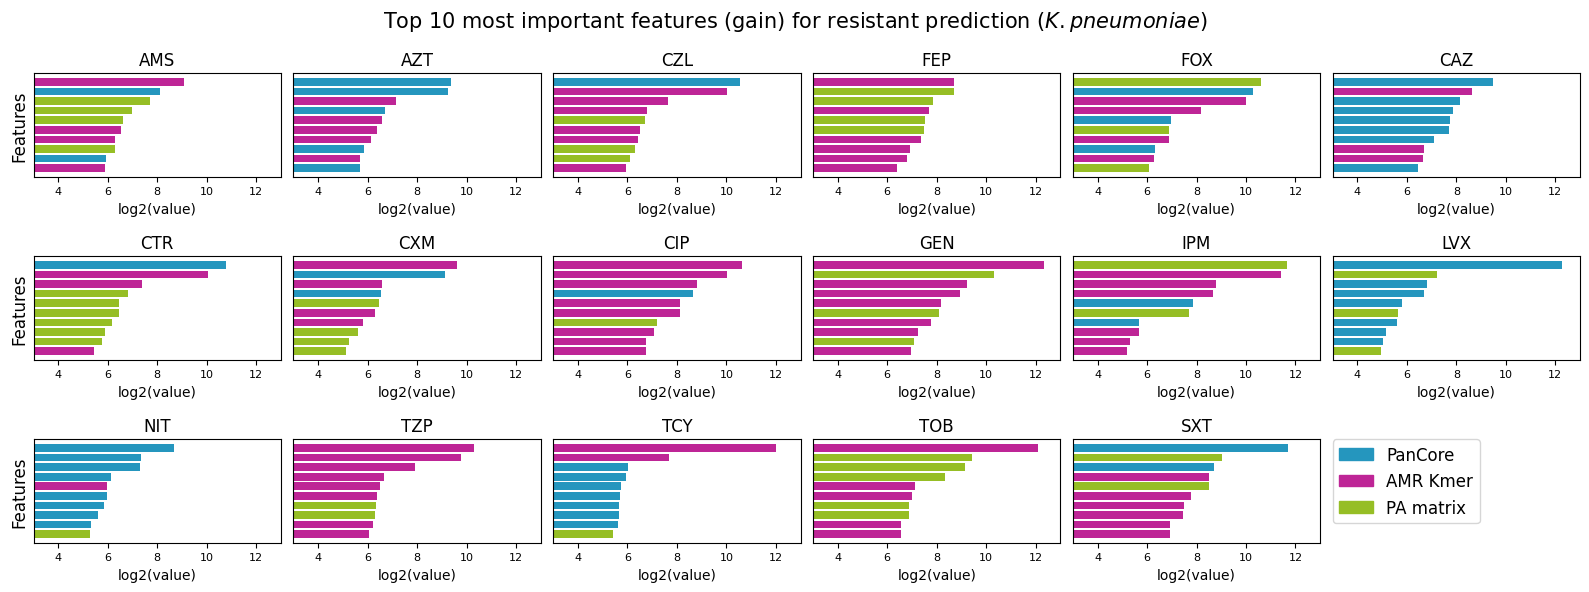

In [108]:
style.use('default')
plt.figure(figsize=(16, 6)); plt.suptitle('Top 10 most important features (gain) for resistant prediction ($\it{K. pneumoniae}$)', fontsize=15)
for i in range(17):
    ax = plt.subplot(3, 6, i+1)
    ax.barh(ft_rank_Kp_gain[i][0], np.log2(ft_rank_Kp_gain[i][1]), height=0.8, 
            color=np.where(np.isin(ft_rank_Kp_gain[i][0], Kp_Core.columns), '#2596be', 
                           np.where(np.isin(ft_rank_Kp_gain[i][0], Kp_AMR_Kmer.columns), '#be2596', '#96be25')))
    if i%6 == 0:
        plt.ylabel('Features', fontsize=12)
    plt.xticks(fontsize=8)
    plt.title(Kp_metadata.columns[i], fontsize=12)
    plt.xlabel('log2(value)', fontsize=10); plt.yticks(ticks=[]); 
    plt.xlim((3, 13))
    plt.tight_layout(h_pad=1.3, w_pad=0.9)
    # plt.show()
plt.subplot(3, 6, 18).axis('off')
legend_custom = [
    Patch(color='#2596be', label='PanCore'),
    Patch(color='#be2596', label='AMR Kmer'),
    Patch(color='#96be25', label='PA matrix')
]
plt.legend(handles=legend_custom, loc='upper left', borderaxespad=0., fontsize=12)
# plt.savefig('figure_ft_importance/fts_ranking_Kp_gain.jpg', format='jpg', dpi=400)
plt.show()

In [70]:
# same for type_importance = 'split'